# 17. Bag of Words

In [1]:
import codecs
import pandas as pd

from konlpy.tag import Twitter
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.utils.data as Data

import numpy as np
import random

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 17.1 Prepare Data

In [3]:
f = codecs.open("data/reviews.txt", 'r', 'utf-8')
f.read()[:500]

'# G마켓에 좋은 평만 있어서 사봤는데.. 정말 진짜 진짜 사지마세요. 개. 쓰. 레. 기 (진심) 입니다. 액정부터 짜증나는 TN패널에, 하드 SSD인걸로 알았는데, 속도는 저질 SD카드 꽂아 놓은것 같습니다. 정말 느려터집니다. 저는 단지 인터넷 뱅킹만 할려고, 샀단 말입니다. 그런데 인터넷 뱅킹 프로그램까는데만 10~20분 걸립니다. 뭐약!! 이게!! 분노로 인해 볼때마다 짜증납니다. 밤에 잠도 안오고요.. 사시면 분명 후회하실겁니다. 아! 진짜 G마켓 프리미엄평으로 실날하게 사진찍어서 올리려고했는데, 먹고 산다고 바빠서 프리미엄 평 못 올린게 정말 천추의 한이네요!!\n# 원래 그런 줄 알고 사는 "저가 제품"이라고 생각합니다만. IPS라는 언급이 없으니 당연히 TN 패널일 테고, EMMC는 SSD가 아니고 SD 카드 내장된 것 같은 것이라 원래 SSD보다 느린 것이고, CPU도 아톰이니 뭐 당연히 느리죠. 그런 것 다 감안하고 "싸고 가볍다"는 조건으로 사는 제품인데요. 뭐 '

## 17.2 Extract Setences

In [4]:
keywords = ["발열", "소음"]

for keyword in keywords :
    temp_list = []
    save_name = "data/reviews_" + keyword + ".txt"
    f = codecs.open("data/reviews.txt", 'r', 'utf-8')
    t = codecs.open(save_name, 'w', 'utf-8')
    
    while True:
        line = f.readline()
        if not line: break
        if keyword in line :
            temp_list.append(line)
            
    set_list = list(set(temp_list))
    
    for item in set_list :
        t.write(item)
        
    f.close()
    t.close()

In [5]:
f = codecs.open("data/reviews_발열.txt", 'r', 'utf-8')
f.read()[:500]

'# 발열 심하지않아서 좋네요\n# 배송완전빠르구요부팅속도 진짜 빨라요단점은 게임하면 팬소리가좀나는편인데 그만큼발열을 안생길려고 팬이 돌아가겠죵ㅎ 만족하고 잘쓰겠습니다\n# 무게는 무거운건 사실이고 일단 배틀그라운드 아주 잘 돌아갑니다 당근 낮은상태에서(울트라해봤자 인터넷끊킴이 있어서 필요없음) 발열 : 많이나는데 어차피 노트북은 게임하면 이정도면 다 그런것 같음 배터리 : 당연히 충전하면서합니다 중요한건 배틀그라운드를 쾌적하게 합니다!\n# 음 일단 처음 든 생각은 왜이렇게 느린가였고 처음에 키자마자 이것저것 설치하래서설치도 오래하길래 씻고 왔는데도 설치중이더군요 뭐 그렇게 냅두다가 다되서 이것저것 만져보는데 왜이렇게 발열은 심해요 ㅋㅋㅋㅋㅋㅋㅋ 딴 후기보면 발열을 다 잡았더니 그러던데 키보드 만지니까 뜨끈뜨끈하던데요... 그리고 오피스인가 그거 인증하려고 제품키 보니까 바코드 그런건 있는데 보통 바코드위에 숫자써있어야하는거 아닌가요? 없던데요.. 바코드만있고... 이 사기당한 기분.. '

## 17.3 Load Scored Data

In [6]:
filename = "data/score_발열.xlsx"
sheet_name = "Sheet1"
data = pd.read_excel(filename, sheet_name = sheet_name, header = 0)

csv_data = [item.replace("#", "").strip() for item in data['Review']]
csv_label = data['Score']

In [7]:
csv_data[:5]

['발열히 심한거 같은데 여름이라 그런가?..',
 '발열이좀 심한거 같아서 걱정이에요',
 '발열이심하더라구요',
 '발열이너무심한게 제일큰 단점인것 같고 그외에 불편한점은',
 '발열이...정말...심합니다']

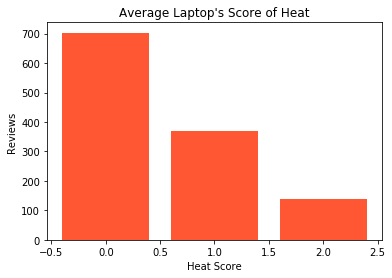

In [8]:
scores = [sum(csv_label == 0), sum(csv_label == 1), sum(csv_label == 2)]
plt.bar(range(len(scores)),scores, color="#ff5733")

plt.title("Average Laptop's Score of Heat")
plt.xlabel("Heat Score")
plt.ylabel("Reviews")

plt.show()

## 17.4 Bag of Words

In [9]:
twitter = Twitter()
doc = []

for sentence in csv_data :
    results= []
    tokens = twitter.pos(sentence, norm=True, stem=True)
        
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
    doc.append(" ".join(results).strip())

In [10]:
doc[:5]

['발열 히 심하다 같다 여름 그 런가',
 '발열 이 좀 심하다 같다 걱정',
 '발열 심하다',
 '발열 이 너무 심하다 제일 크다 단점 것 같다 그 외 불편하다 점',
 '발열 정말 심하다']

In [11]:
# CountVectorizer
cnv = CountVectorizer(ngram_range=(1,1), min_df = 3)

data = cnv.fit_transform(doc).toarray()
label = csv_label.values

In [12]:
# TF-IDF Vectorizer
# tfidv = TfidfVectorizer().fit(data)
# data = tfidv.transform(data).toarray()

# data = pd.DataFrame(data)
# data = (data - data.mean()) / (data.max() - data.min() + 1)

In [13]:
cnv.vocabulary_

{'10': 0,
 '100': 1,
 '50': 2,
 '70': 3,
 'as': 4,
 'cpu': 5,
 'ips': 6,
 'ssd': 7,
 'ㅜㅜ': 8,
 'ㅠㅠ': 9,
 '가격': 10,
 '가다': 11,
 '가볍다': 12,
 '가성': 13,
 '감다': 14,
 '같다': 15,
 '개선': 16,
 '거의': 17,
 '걱정': 18,
 '걸리다': 19,
 '게임': 20,
 '겨울': 21,
 '고민': 22,
 '고사': 23,
 '관리': 24,
 '괜찮다': 25,
 '굉장하다': 26,
 '구매': 27,
 '구성': 28,
 '그냥': 29,
 '그래도': 30,
 '그래픽': 31,
 '그램': 32,
 '그렇게': 33,
 '그렇다': 34,
 '그리다': 35,
 '기능': 36,
 '기다': 37,
 '기본': 38,
 '까지': 39,
 '깔끔하다': 40,
 '끊기다': 41,
 '나다': 42,
 '나쁘다': 43,
 '나오다': 44,
 '낮다': 45,
 '내다': 46,
 '너무': 47,
 '노트': 48,
 '노트북': 49,
 '놀라다': 50,
 '높다': 51,
 '느껴지다': 52,
 '느끼다': 53,
 '느낌': 54,
 '느리다': 55,
 '늘다': 56,
 '능력': 57,
 '다니다': 58,
 '다른': 59,
 '다소': 60,
 '단점': 61,
 '대다': 62,
 '대단하다': 63,
 '대만': 64,
 '대비': 65,
 '던지다': 66,
 '데스크탑': 67,
 '돌다': 68,
 '돌리다': 69,
 '돌아가다': 70,
 '돼다': 71,
 '되다': 72,
 '되어다': 73,
 '두다': 74,
 '들다': 75,
 '듭니': 76,
 '등등': 77,
 '디자인': 78,
 '따다': 79,
 '따뜻하다': 80,
 '따르다': 81,
 '딱하다': 82,
 '때문': 83,
 '떨어지다': 84,
 '또한': 85,
 '뛰어나다': 86,
 '뜨겁다': 8

## 17.5 Train-Test Split

In [14]:
dim = len(cnv.vocabulary_)

In [15]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)

print(len(train_data))
print(len(test_data))

908
303


In [16]:
x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

In [17]:
y.size() , x.size()

(torch.Size([908]), torch.Size([908, 297]))

In [18]:
train_data = Data.TensorDataset(x, y)

batch_size = 10

train_loader  = Data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1,
                                          drop_last = True)

## 17.6 Define and Train Model

In [19]:
linear1 = nn.Linear(dim, 200, bias = True)
linear2 = nn.Linear(200, 3, bias = True)
relu = nn.ReLU()

model = nn.Sequential(linear1, relu, linear2)

In [20]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 50

In [22]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/50], lter [20/90] Loss: 0.9351
Epoch [1/50], lter [40/90] Loss: 1.0617
Epoch [1/50], lter [60/90] Loss: 0.4107
Epoch [1/50], lter [80/90] Loss: 0.7498
Epoch [2/50], lter [20/90] Loss: 0.4571
Epoch [2/50], lter [40/90] Loss: 0.5827
Epoch [2/50], lter [60/90] Loss: 0.5462
Epoch [2/50], lter [80/90] Loss: 0.3035
Epoch [3/50], lter [20/90] Loss: 0.2913
Epoch [3/50], lter [40/90] Loss: 0.5958
Epoch [3/50], lter [60/90] Loss: 0.5010
Epoch [3/50], lter [80/90] Loss: 0.1068
Epoch [4/50], lter [20/90] Loss: 0.4167
Epoch [4/50], lter [40/90] Loss: 0.2429
Epoch [4/50], lter [60/90] Loss: 0.5705
Epoch [4/50], lter [80/90] Loss: 0.5105
Epoch [5/50], lter [20/90] Loss: 0.2562
Epoch [5/50], lter [40/90] Loss: 0.4726
Epoch [5/50], lter [60/90] Loss: 0.0576
Epoch [5/50], lter [80/90] Loss: 0.0625
Epoch [6/50], lter [20/90] Loss: 0.0676
Epoch [6/50], lter [40/90] Loss: 0.5286
Epoch [6/50], lter [60/90] Loss: 0.5501
Epoch [6/50], lter [80/90] Loss: 0.3513
Epoch [7/50], lter [20/90] Loss: 0.3333


## 17.7 Test Model

In [23]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)

test_data = Data.TensorDataset(x, y)

test_loader  = Data.DataLoader(dataset=test_data,
                                          batch_size=1,
                                          shuffle=True)

In [24]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, pre = torch.max(outputs.data, 1)
    total += 1
    correct += (pre == labels).sum()
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 98.127753 %


## 17.8 Test Sentence

In [25]:
def IsitHot(string) :
    
    results= []
    tokens = twitter.pos(string, norm=True, stem=True)

    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
   
    sample = cnv.transform([" ".join(results).strip()]).toarray()
    sample = torch.from_numpy(sample).type(torch.FloatTensor)
    outputs = model(sample)
    pre = torch.max(outputs.data, 1)[1].numpy()
    
    if pre == 0 : 
        print("분석 결과 : 발열 거의 없음")
    elif pre == 1 :
        print("분석 결과 : 발열 조금 있음")
    else :
        print("분석 결과 : 발열 매우 심함")

In [26]:
IsitHot("노트북이 너무 뜨거워요")

분석 결과 : 발열 매우 심함


In [27]:
IsitHot("발열을 잘 잡았네요")

분석 결과 : 발열 거의 없음
